In [10]:
%pip install albumentations

     |████████████████████████████████| 125 kB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.8 MB 41.4 MB/s eta 0:00:01
     |████████████████████████████████| 49.2 MB 61.5 MB/s eta 0:00:01
     |████████████████████████████████| 36.5 MB 65.4 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 75.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 102.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 67.0 MB/s eta 0:00:01
     |████████████████████████████████| 219 kB 79.3 MB/s eta 0:00:01
     |████████████████████████████████| 313 kB 73.4 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 96.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import albumentations as A
import torch
import numpy as np
from torchsummary import summary

from data import CIFAR10WithAlbumentations
from model import Net
from utils_train import train, test
from utils_plot import imshow

In [2]:
train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(),
            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=108, mask_fill_value = None),
            A.Normalize((0.5, 0.49, 0.45), (0.23, 0.23, 0.25), always_apply=True)
        ])
test_transforms = A.Compose([
            A.Normalize((0.5, 0.49, 0.45), (0.23, 0.23, 0.25), always_apply=True)
        ])
train_ds = CIFAR10WithAlbumentations('./data', train=True, download=True, transform=train_transforms)
test_ds = CIFAR10WithAlbumentations('./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)


CUDA Available? True


In [4]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('[Train]')
print(' - Numpy Shape:', train_ds.data.shape)
print(' - Tensor Shape:', images.size())
print(' - min:', np.min(train_ds.data))
print(' - max:', np.max(train_ds.data))
print(' - mean R:', torch.mean(images[:, 0, :, :]))
print(' - std R:', torch.std(images[:, 0, :, :]))
print(' - var R:', torch.var(images[:, 0, :, :]))

print(' - mean G:', torch.mean(images[:, 1, :, :]))
print(' - std G:', torch.std(images[:, 1, :, :]))
print(' - var G:', torch.var(images[:, 1, :, :]))

print(' - mean B:', torch.mean(images[:, 2, :, :]))
print(' - std B:', torch.std(images[:, 2, :, :]))
print(' - var B:', torch.var(images[:, 2, :, :]))

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([128, 3, 32, 32])
 - min: 0
 - max: 255
 - mean R: tensor(-0.0823)
 - std R: tensor(1.0197)
 - var R: tensor(1.0397)
 - mean G: tensor(-0.0516)
 - std G: tensor(1.0043)
 - var G: tensor(1.0086)
 - mean B: tensor(0.0017)
 - std B: tensor(0.9948)
 - var B: tensor(0.9896)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


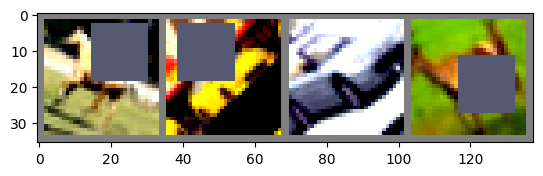

horse automobile automobile deer 


In [5]:
# get some random training images
import torchvision


batch_size=4
dataiter = iter(train_loader)
classes = train_ds.classes
images, labels = next(dataiter)
sampled_images = images[0: batch_size]
sampled_labels = labels[0: batch_size]

# show images
imshow(torchvision.utils.make_grid(sampled_images))
# print labels
print(' '.join(f'{classes[sampled_labels[j]]:5s}' for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


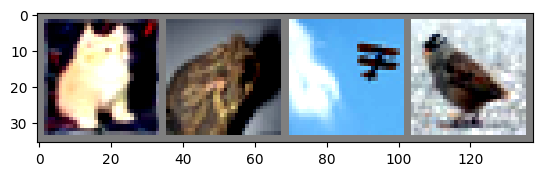

cat   frog  airplane bird 


In [6]:
batch_size=4
dataiter = iter(test_loader)
classes = train_ds.classes
images, labels = next(dataiter)
sampled_images = images[0: batch_size]
sampled_labels = labels[0: batch_size]

# show images
imshow(torchvision.utils.make_grid(sampled_images))
# print labels
print(' '.join(f'{classes[sampled_labels[j]]:5s}' for j in range(batch_size)))

In [7]:
# !pip install torchsummary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
              ReLU-2            [-1, 3, 32, 32]               0
       BatchNorm2d-3            [-1, 3, 32, 32]               6
           Dropout-4            [-1, 3, 32, 32]               0
            Conv2d-5           [-1, 10, 32, 32]              30
              ReLU-6           [-1, 10, 32, 32]               0
       BatchNorm2d-7           [-1, 10, 32, 32]              20
           Dropout-8           [-1, 10, 32, 32]               0
            Conv2d-9           [-1, 10, 28, 28]             900
             ReLU-10           [-1, 10, 28, 28]               0
      BatchNorm2d-11           [-1, 10, 28, 28]              20
          Dropout-12           [-1, 10, 28, 28]               0
           Conv2d-13           [-1, 20, 28, 28]           1,800
             ReLU-14           [-1

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


In [9]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch
model =  Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=100, verbose=True)

EPOCHS = 85
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test(model, device, test_loader, test_losses, test_acc)


Adjusting learning rate of group 0 to 1.0000e-02.
EPOCH: 0


Loss=1.6495164632797241 Batch_id=390 Accuracy=32.27: 100%|██████████| 391/391 [00:07<00:00, 53.25it/s]

Adjusting learning rate of group 0 to 9.9975e-03.



Test set: Average loss: 1.5611, Accuracy: 4284/10000 (42.84%)

EPOCH: 1


Loss=1.7074143886566162 Batch_id=390 Accuracy=41.13: 100%|██████████| 391/391 [00:06<00:00, 56.07it/s]

Adjusting learning rate of group 0 to 9.9901e-03.



Test set: Average loss: 1.3442, Accuracy: 5162/10000 (51.62%)

EPOCH: 2


Loss=1.2097843885421753 Batch_id=390 Accuracy=45.66: 100%|██████████| 391/391 [00:07<00:00, 55.63it/s]

Adjusting learning rate of group 0 to 9.9778e-03.



Test set: Average loss: 1.2116, Accuracy: 5661/10000 (56.61%)

EPOCH: 3


Loss=1.479993224143982 Batch_id=390 Accuracy=49.62: 100%|██████████| 391/391 [00:07<00:00, 54.81it/s] 

Adjusting learning rate of group 0 to 9.9606e-03.



Test set: Average loss: 1.1365, Accuracy: 5945/10000 (59.45%)

EPOCH: 4


Loss=1.2315208911895752 Batch_id=390 Accuracy=52.38: 100%|██████████| 391/391 [00:07<00:00, 54.62it/s]

Adjusting learning rate of group 0 to 9.9384e-03.



Test set: Average loss: 1.0611, Accuracy: 6340/10000 (63.40%)

EPOCH: 5


Loss=1.1830356121063232 Batch_id=390 Accuracy=55.23: 100%|██████████| 391/391 [00:07<00:00, 54.42it/s]

Adjusting learning rate of group 0 to 9.9114e-03.



Test set: Average loss: 1.0010, Accuracy: 6443/10000 (64.43%)

EPOCH: 6


Loss=1.1451151371002197 Batch_id=390 Accuracy=56.88: 100%|██████████| 391/391 [00:07<00:00, 55.22it/s]

Adjusting learning rate of group 0 to 9.8796e-03.



Test set: Average loss: 0.9845, Accuracy: 6566/10000 (65.66%)

EPOCH: 7


Loss=1.3155739307403564 Batch_id=390 Accuracy=58.97: 100%|██████████| 391/391 [00:07<00:00, 54.59it/s]

Adjusting learning rate of group 0 to 9.8429e-03.



Test set: Average loss: 0.8898, Accuracy: 6899/10000 (68.99%)

EPOCH: 8


Loss=1.174446702003479 Batch_id=390 Accuracy=60.22: 100%|██████████| 391/391 [00:07<00:00, 53.85it/s] 

Adjusting learning rate of group 0 to 9.8015e-03.



Test set: Average loss: 0.8469, Accuracy: 7112/10000 (71.12%)

EPOCH: 9


Loss=1.1017210483551025 Batch_id=390 Accuracy=61.34: 100%|██████████| 391/391 [00:07<00:00, 54.69it/s]

Adjusting learning rate of group 0 to 9.7553e-03.



Test set: Average loss: 0.8280, Accuracy: 7221/10000 (72.21%)

EPOCH: 10


Loss=1.0981327295303345 Batch_id=390 Accuracy=62.57: 100%|██████████| 391/391 [00:07<00:00, 53.68it/s]

Adjusting learning rate of group 0 to 9.7044e-03.



Test set: Average loss: 0.7698, Accuracy: 7344/10000 (73.44%)

EPOCH: 11


Loss=1.1522186994552612 Batch_id=390 Accuracy=63.01: 100%|██████████| 391/391 [00:07<00:00, 53.12it/s]

Adjusting learning rate of group 0 to 9.6489e-03.



Test set: Average loss: 0.7749, Accuracy: 7346/10000 (73.46%)

EPOCH: 12


Loss=1.0087916851043701 Batch_id=390 Accuracy=64.07: 100%|██████████| 391/391 [00:07<00:00, 54.01it/s]

Adjusting learning rate of group 0 to 9.5888e-03.



Test set: Average loss: 0.7605, Accuracy: 7334/10000 (73.34%)

EPOCH: 13


Loss=1.0103617906570435 Batch_id=390 Accuracy=64.53: 100%|██████████| 391/391 [00:07<00:00, 53.63it/s]

Adjusting learning rate of group 0 to 9.5241e-03.



Test set: Average loss: 0.7162, Accuracy: 7514/10000 (75.14%)

EPOCH: 14


Loss=0.9927427172660828 Batch_id=390 Accuracy=65.51: 100%|██████████| 391/391 [00:07<00:00, 51.23it/s]

Adjusting learning rate of group 0 to 9.4550e-03.



Test set: Average loss: 0.7092, Accuracy: 7539/10000 (75.39%)

EPOCH: 15


Loss=1.0010308027267456 Batch_id=390 Accuracy=66.07: 100%|██████████| 391/391 [00:07<00:00, 54.32it/s]

Adjusting learning rate of group 0 to 9.3815e-03.



Test set: Average loss: 0.6744, Accuracy: 7685/10000 (76.85%)

EPOCH: 16


Loss=1.1703746318817139 Batch_id=390 Accuracy=66.31: 100%|██████████| 391/391 [00:07<00:00, 53.62it/s]

Adjusting learning rate of group 0 to 9.3037e-03.



Test set: Average loss: 0.7080, Accuracy: 7535/10000 (75.35%)

EPOCH: 17


Loss=0.8820401430130005 Batch_id=390 Accuracy=67.08: 100%|██████████| 391/391 [00:07<00:00, 54.22it/s]

Adjusting learning rate of group 0 to 9.2216e-03.



Test set: Average loss: 0.6474, Accuracy: 7766/10000 (77.66%)

EPOCH: 18


Loss=0.8942304849624634 Batch_id=390 Accuracy=67.58: 100%|██████████| 391/391 [00:07<00:00, 54.50it/s]

Adjusting learning rate of group 0 to 9.1354e-03.



Test set: Average loss: 0.6600, Accuracy: 7732/10000 (77.32%)

EPOCH: 19


Loss=0.8493603467941284 Batch_id=390 Accuracy=67.73: 100%|██████████| 391/391 [00:07<00:00, 51.90it/s]

Adjusting learning rate of group 0 to 9.0451e-03.



Test set: Average loss: 0.6280, Accuracy: 7820/10000 (78.20%)

EPOCH: 20


Loss=0.8857865333557129 Batch_id=390 Accuracy=68.62: 100%|██████████| 391/391 [00:07<00:00, 53.37it/s]

Adjusting learning rate of group 0 to 8.9508e-03.



Test set: Average loss: 0.6193, Accuracy: 7806/10000 (78.06%)

EPOCH: 21


Loss=0.9115622639656067 Batch_id=390 Accuracy=68.74: 100%|██████████| 391/391 [00:07<00:00, 54.59it/s]

Adjusting learning rate of group 0 to 8.8526e-03.



Test set: Average loss: 0.6440, Accuracy: 7793/10000 (77.93%)

EPOCH: 22


Loss=0.7237640619277954 Batch_id=390 Accuracy=69.15: 100%|██████████| 391/391 [00:07<00:00, 53.64it/s]

Adjusting learning rate of group 0 to 8.7506e-03.



Test set: Average loss: 0.6018, Accuracy: 7912/10000 (79.12%)

EPOCH: 23


Loss=0.9945931434631348 Batch_id=390 Accuracy=69.35: 100%|██████████| 391/391 [00:07<00:00, 55.05it/s]

Adjusting learning rate of group 0 to 8.6448e-03.



Test set: Average loss: 0.5995, Accuracy: 7942/10000 (79.42%)

EPOCH: 24


Loss=1.043685793876648 Batch_id=390 Accuracy=69.84: 100%|██████████| 391/391 [00:07<00:00, 54.79it/s] 

Adjusting learning rate of group 0 to 8.5355e-03.



Test set: Average loss: 0.5788, Accuracy: 8021/10000 (80.21%)

EPOCH: 25


Loss=1.1027578115463257 Batch_id=390 Accuracy=69.80: 100%|██████████| 391/391 [00:07<00:00, 55.40it/s]

Adjusting learning rate of group 0 to 8.4227e-03.



Test set: Average loss: 0.6099, Accuracy: 7940/10000 (79.40%)

EPOCH: 26


Loss=0.7640049457550049 Batch_id=390 Accuracy=70.02: 100%|██████████| 391/391 [00:07<00:00, 53.70it/s]

Adjusting learning rate of group 0 to 8.3066e-03.



Test set: Average loss: 0.5575, Accuracy: 8095/10000 (80.95%)

EPOCH: 27


Loss=0.6393365263938904 Batch_id=390 Accuracy=70.66: 100%|██████████| 391/391 [00:07<00:00, 52.63it/s]


Adjusting learning rate of group 0 to 8.1871e-03.

Test set: Average loss: 0.5776, Accuracy: 8001/10000 (80.01%)

EPOCH: 28


Loss=0.974582850933075 Batch_id=390 Accuracy=70.86: 100%|██████████| 391/391 [00:07<00:00, 54.30it/s] 

Adjusting learning rate of group 0 to 8.0645e-03.



Test set: Average loss: 0.5634, Accuracy: 8048/10000 (80.48%)

EPOCH: 29


Loss=0.6809231638908386 Batch_id=390 Accuracy=70.96: 100%|██████████| 391/391 [00:07<00:00, 53.88it/s]

Adjusting learning rate of group 0 to 7.9389e-03.



Test set: Average loss: 0.5601, Accuracy: 8087/10000 (80.87%)

EPOCH: 30


Loss=0.8651199340820312 Batch_id=390 Accuracy=71.08: 100%|██████████| 391/391 [00:07<00:00, 54.15it/s]


Adjusting learning rate of group 0 to 7.8104e-03.

Test set: Average loss: 0.5778, Accuracy: 8018/10000 (80.18%)

EPOCH: 31


Loss=1.077627182006836 Batch_id=390 Accuracy=71.69: 100%|██████████| 391/391 [00:07<00:00, 54.67it/s] 

Adjusting learning rate of group 0 to 7.6791e-03.



Test set: Average loss: 0.5488, Accuracy: 8104/10000 (81.04%)

EPOCH: 32


Loss=0.6154687404632568 Batch_id=390 Accuracy=71.55: 100%|██████████| 391/391 [00:07<00:00, 54.77it/s]

Adjusting learning rate of group 0 to 7.5452e-03.



Test set: Average loss: 0.5321, Accuracy: 8188/10000 (81.88%)

EPOCH: 33


Loss=0.920291543006897 Batch_id=390 Accuracy=72.24: 100%|██████████| 391/391 [00:07<00:00, 54.90it/s] 


Adjusting learning rate of group 0 to 7.4088e-03.

Test set: Average loss: 0.5439, Accuracy: 8128/10000 (81.28%)

EPOCH: 34


Loss=0.9273964762687683 Batch_id=390 Accuracy=71.99: 100%|██████████| 391/391 [00:07<00:00, 52.73it/s]

Adjusting learning rate of group 0 to 7.2700e-03.



Test set: Average loss: 0.5410, Accuracy: 8164/10000 (81.64%)

EPOCH: 35


Loss=0.7916900515556335 Batch_id=390 Accuracy=71.80: 100%|██████████| 391/391 [00:07<00:00, 53.33it/s]

Adjusting learning rate of group 0 to 7.1289e-03.



Test set: Average loss: 0.5300, Accuracy: 8213/10000 (82.13%)

EPOCH: 36


Loss=0.9281024932861328 Batch_id=390 Accuracy=72.49: 100%|██████████| 391/391 [00:07<00:00, 54.42it/s]

Adjusting learning rate of group 0 to 6.9857e-03.



Test set: Average loss: 0.5215, Accuracy: 8234/10000 (82.34%)

EPOCH: 37


Loss=0.6873153448104858 Batch_id=390 Accuracy=72.62: 100%|██████████| 391/391 [00:07<00:00, 53.78it/s]

Adjusting learning rate of group 0 to 6.8406e-03.



Test set: Average loss: 0.5344, Accuracy: 8200/10000 (82.00%)

EPOCH: 38


Loss=0.7948567867279053 Batch_id=390 Accuracy=72.98: 100%|██████████| 391/391 [00:07<00:00, 54.26it/s]


Adjusting learning rate of group 0 to 6.6937e-03.

Test set: Average loss: 0.5098, Accuracy: 8255/10000 (82.55%)

EPOCH: 39


Loss=0.8048678636550903 Batch_id=390 Accuracy=72.77: 100%|██████████| 391/391 [00:07<00:00, 53.50it/s]

Adjusting learning rate of group 0 to 6.5451e-03.



Test set: Average loss: 0.5108, Accuracy: 8249/10000 (82.49%)

EPOCH: 40


Loss=0.7649175524711609 Batch_id=390 Accuracy=73.44: 100%|██████████| 391/391 [00:07<00:00, 53.88it/s]

Adjusting learning rate of group 0 to 6.3950e-03.



Test set: Average loss: 0.5030, Accuracy: 8313/10000 (83.13%)

EPOCH: 41


Loss=0.642551839351654 Batch_id=390 Accuracy=73.38: 100%|██████████| 391/391 [00:07<00:00, 52.79it/s] 

Adjusting learning rate of group 0 to 6.2434e-03.



Test set: Average loss: 0.5306, Accuracy: 8211/10000 (82.11%)

EPOCH: 42


Loss=0.890531063079834 Batch_id=390 Accuracy=73.15: 100%|██████████| 391/391 [00:07<00:00, 54.77it/s] 


Adjusting learning rate of group 0 to 6.0907e-03.

Test set: Average loss: 0.5071, Accuracy: 8297/10000 (82.97%)

EPOCH: 43


Loss=0.8338201642036438 Batch_id=390 Accuracy=73.28: 100%|██████████| 391/391 [00:07<00:00, 54.49it/s]


Adjusting learning rate of group 0 to 5.9369e-03.

Test set: Average loss: 0.5020, Accuracy: 8296/10000 (82.96%)

EPOCH: 44


Loss=0.9078485369682312 Batch_id=390 Accuracy=73.84: 100%|██████████| 391/391 [00:07<00:00, 53.31it/s]

Adjusting learning rate of group 0 to 5.7822e-03.



Test set: Average loss: 0.5100, Accuracy: 8277/10000 (82.77%)

EPOCH: 45


Loss=0.9344244003295898 Batch_id=390 Accuracy=74.11: 100%|██████████| 391/391 [00:07<00:00, 54.97it/s]


Adjusting learning rate of group 0 to 5.6267e-03.

Test set: Average loss: 0.4978, Accuracy: 8289/10000 (82.89%)

EPOCH: 46


Loss=0.6016795039176941 Batch_id=390 Accuracy=74.13: 100%|██████████| 391/391 [00:07<00:00, 54.67it/s]

Adjusting learning rate of group 0 to 5.4705e-03.



Test set: Average loss: 0.4902, Accuracy: 8339/10000 (83.39%)

EPOCH: 47


Loss=0.7154718637466431 Batch_id=390 Accuracy=74.35: 100%|██████████| 391/391 [00:07<00:00, 54.50it/s] 

Adjusting learning rate of group 0 to 5.3140e-03.



Test set: Average loss: 0.4794, Accuracy: 8396/10000 (83.96%)

EPOCH: 48


Loss=0.8531876802444458 Batch_id=390 Accuracy=74.63: 100%|██████████| 391/391 [00:07<00:00, 55.26it/s]

Adjusting learning rate of group 0 to 5.1571e-03.



Test set: Average loss: 0.4857, Accuracy: 8359/10000 (83.59%)

EPOCH: 49


Loss=0.6314316987991333 Batch_id=390 Accuracy=74.60: 100%|██████████| 391/391 [00:07<00:00, 53.28it/s]

Adjusting learning rate of group 0 to 5.0000e-03.



Test set: Average loss: 0.4855, Accuracy: 8346/10000 (83.46%)

EPOCH: 50


Loss=0.6910220384597778 Batch_id=390 Accuracy=74.83: 100%|██████████| 391/391 [00:07<00:00, 54.04it/s]

Adjusting learning rate of group 0 to 4.8429e-03.



Test set: Average loss: 0.4862, Accuracy: 8353/10000 (83.53%)

EPOCH: 51


Loss=0.7505550384521484 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:07<00:00, 53.59it/s]

Adjusting learning rate of group 0 to 4.6860e-03.



Test set: Average loss: 0.4791, Accuracy: 8395/10000 (83.95%)

EPOCH: 52


Loss=0.7670813798904419 Batch_id=390 Accuracy=75.24: 100%|██████████| 391/391 [00:07<00:00, 53.50it/s] 

Adjusting learning rate of group 0 to 4.5295e-03.



Test set: Average loss: 0.4720, Accuracy: 8396/10000 (83.96%)

EPOCH: 53


Loss=0.7009052038192749 Batch_id=390 Accuracy=75.27: 100%|██████████| 391/391 [00:07<00:00, 52.65it/s] 

Adjusting learning rate of group 0 to 4.3733e-03.



Test set: Average loss: 0.4788, Accuracy: 8381/10000 (83.81%)

EPOCH: 54


Loss=0.6089791655540466 Batch_id=390 Accuracy=75.26: 100%|██████████| 391/391 [00:07<00:00, 52.60it/s]

Adjusting learning rate of group 0 to 4.2178e-03.



Test set: Average loss: 0.4793, Accuracy: 8390/10000 (83.90%)

EPOCH: 55


Loss=0.7072535157203674 Batch_id=390 Accuracy=75.33: 100%|██████████| 391/391 [00:07<00:00, 54.24it/s]

Adjusting learning rate of group 0 to 4.0631e-03.



Test set: Average loss: 0.4639, Accuracy: 8404/10000 (84.04%)

EPOCH: 56


Loss=0.9707894325256348 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:07<00:00, 52.46it/s] 

Adjusting learning rate of group 0 to 3.9093e-03.



Test set: Average loss: 0.4769, Accuracy: 8378/10000 (83.78%)

EPOCH: 57


Loss=1.0612032413482666 Batch_id=390 Accuracy=75.50: 100%|██████████| 391/391 [00:07<00:00, 52.23it/s]

Adjusting learning rate of group 0 to 3.7566e-03.



Test set: Average loss: 0.4649, Accuracy: 8422/10000 (84.22%)

EPOCH: 58


Loss=0.7258801460266113 Batch_id=390 Accuracy=75.44: 100%|██████████| 391/391 [00:07<00:00, 52.75it/s] 

Adjusting learning rate of group 0 to 3.6050e-03.



Test set: Average loss: 0.4719, Accuracy: 8403/10000 (84.03%)

EPOCH: 59


Loss=0.732791543006897 Batch_id=390 Accuracy=75.55: 100%|██████████| 391/391 [00:07<00:00, 53.88it/s]  

Adjusting learning rate of group 0 to 3.4549e-03.



Test set: Average loss: 0.4587, Accuracy: 8444/10000 (84.44%)

EPOCH: 60


Loss=0.5443053841590881 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:07<00:00, 54.63it/s]

Adjusting learning rate of group 0 to 3.3063e-03.



Test set: Average loss: 0.4520, Accuracy: 8459/10000 (84.59%)

EPOCH: 61


Loss=0.7557817697525024 Batch_id=390 Accuracy=76.04: 100%|██████████| 391/391 [00:07<00:00, 54.13it/s] 

Adjusting learning rate of group 0 to 3.1594e-03.



Test set: Average loss: 0.4541, Accuracy: 8445/10000 (84.45%)

EPOCH: 62


Loss=0.796240508556366 Batch_id=390 Accuracy=76.04: 100%|██████████| 391/391 [00:07<00:00, 54.97it/s]  


Adjusting learning rate of group 0 to 3.0143e-03.

Test set: Average loss: 0.4566, Accuracy: 8420/10000 (84.20%)

EPOCH: 63


Loss=0.6662209033966064 Batch_id=390 Accuracy=76.38: 100%|██████████| 391/391 [00:07<00:00, 54.53it/s] 


Adjusting learning rate of group 0 to 2.8711e-03.

Test set: Average loss: 0.4487, Accuracy: 8485/10000 (84.85%)

EPOCH: 64


Loss=0.78925621509552 Batch_id=390 Accuracy=76.39: 100%|██████████| 391/391 [00:07<00:00, 53.10it/s]   

Adjusting learning rate of group 0 to 2.7300e-03.



Test set: Average loss: 0.4433, Accuracy: 8475/10000 (84.75%)

EPOCH: 65


Loss=0.7890010476112366 Batch_id=390 Accuracy=76.31: 100%|██████████| 391/391 [00:07<00:00, 53.81it/s] 

Adjusting learning rate of group 0 to 2.5912e-03.



Test set: Average loss: 0.4428, Accuracy: 8526/10000 (85.26%)

EPOCH: 66


Loss=0.6942958831787109 Batch_id=390 Accuracy=76.75: 100%|██████████| 391/391 [00:07<00:00, 54.14it/s] 

Adjusting learning rate of group 0 to 2.4548e-03.



Test set: Average loss: 0.4455, Accuracy: 8490/10000 (84.90%)

EPOCH: 67


Loss=0.7158239483833313 Batch_id=390 Accuracy=76.59: 100%|██████████| 391/391 [00:07<00:00, 53.90it/s] 


Adjusting learning rate of group 0 to 2.3209e-03.

Test set: Average loss: 0.4508, Accuracy: 8479/10000 (84.79%)

EPOCH: 68


Loss=0.7589892148971558 Batch_id=390 Accuracy=76.75: 100%|██████████| 391/391 [00:07<00:00, 53.62it/s] 

Adjusting learning rate of group 0 to 2.1896e-03.



Test set: Average loss: 0.4424, Accuracy: 8483/10000 (84.83%)

EPOCH: 69


Loss=0.5694417953491211 Batch_id=390 Accuracy=76.80: 100%|██████████| 391/391 [00:07<00:00, 53.54it/s] 

Adjusting learning rate of group 0 to 2.0611e-03.



Test set: Average loss: 0.4364, Accuracy: 8554/10000 (85.54%)

EPOCH: 70


Loss=0.568416953086853 Batch_id=390 Accuracy=77.11: 100%|██████████| 391/391 [00:07<00:00, 53.31it/s]  

Adjusting learning rate of group 0 to 1.9355e-03.



Test set: Average loss: 0.4350, Accuracy: 8551/10000 (85.51%)

EPOCH: 71


Loss=0.805860698223114 Batch_id=390 Accuracy=76.97: 100%|██████████| 391/391 [00:07<00:00, 52.98it/s]  

Adjusting learning rate of group 0 to 1.8129e-03.



Test set: Average loss: 0.4351, Accuracy: 8525/10000 (85.25%)

EPOCH: 72


Loss=0.7866343259811401 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:07<00:00, 53.64it/s] 

Adjusting learning rate of group 0 to 1.6934e-03.



Test set: Average loss: 0.4408, Accuracy: 8512/10000 (85.12%)

EPOCH: 73


Loss=0.8138516545295715 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:07<00:00, 53.88it/s] 

Adjusting learning rate of group 0 to 1.5773e-03.



Test set: Average loss: 0.4319, Accuracy: 8528/10000 (85.28%)

EPOCH: 74


Loss=0.7559232711791992 Batch_id=390 Accuracy=77.37: 100%|██████████| 391/391 [00:07<00:00, 53.48it/s] 

Adjusting learning rate of group 0 to 1.4645e-03.



Test set: Average loss: 0.4375, Accuracy: 8527/10000 (85.27%)

EPOCH: 75


Loss=0.49154600501060486 Batch_id=390 Accuracy=76.99: 100%|██████████| 391/391 [00:07<00:00, 53.83it/s]


Adjusting learning rate of group 0 to 1.3552e-03.

Test set: Average loss: 0.4355, Accuracy: 8531/10000 (85.31%)

EPOCH: 76


Loss=0.711984395980835 Batch_id=390 Accuracy=77.32: 100%|██████████| 391/391 [00:07<00:00, 54.27it/s]  

Adjusting learning rate of group 0 to 1.2494e-03.



Test set: Average loss: 0.4310, Accuracy: 8545/10000 (85.45%)

EPOCH: 77


Loss=0.8686666488647461 Batch_id=390 Accuracy=77.32: 100%|██████████| 391/391 [00:07<00:00, 54.01it/s] 

Adjusting learning rate of group 0 to 1.1474e-03.



Test set: Average loss: 0.4354, Accuracy: 8537/10000 (85.37%)

EPOCH: 78


Loss=0.5973329544067383 Batch_id=390 Accuracy=77.43: 100%|██████████| 391/391 [00:07<00:00, 54.04it/s] 

Adjusting learning rate of group 0 to 1.0492e-03.



Test set: Average loss: 0.4300, Accuracy: 8528/10000 (85.28%)

EPOCH: 79


Loss=0.6187299489974976 Batch_id=390 Accuracy=77.58: 100%|██████████| 391/391 [00:07<00:00, 51.94it/s] 

Adjusting learning rate of group 0 to 9.5492e-04.



Test set: Average loss: 0.4331, Accuracy: 8538/10000 (85.38%)

EPOCH: 80


Loss=0.7418840527534485 Batch_id=390 Accuracy=77.45: 100%|██████████| 391/391 [00:07<00:00, 52.97it/s] 

Adjusting learning rate of group 0 to 8.6460e-04.



Test set: Average loss: 0.4309, Accuracy: 8532/10000 (85.32%)

EPOCH: 81


Loss=0.710920512676239 Batch_id=390 Accuracy=77.59: 100%|██████████| 391/391 [00:07<00:00, 53.48it/s]  

Adjusting learning rate of group 0 to 7.7836e-04.



Test set: Average loss: 0.4297, Accuracy: 8548/10000 (85.48%)

EPOCH: 82


Loss=0.6920887231826782 Batch_id=390 Accuracy=77.72: 100%|██████████| 391/391 [00:07<00:00, 53.72it/s] 

Adjusting learning rate of group 0 to 6.9629e-04.



Test set: Average loss: 0.4300, Accuracy: 8562/10000 (85.62%)

EPOCH: 83


Loss=0.6389903426170349 Batch_id=390 Accuracy=77.60: 100%|██████████| 391/391 [00:07<00:00, 53.67it/s] 


Adjusting learning rate of group 0 to 6.1847e-04.

Test set: Average loss: 0.4280, Accuracy: 8553/10000 (85.53%)

EPOCH: 84


Loss=0.7053067684173584 Batch_id=390 Accuracy=77.85: 100%|██████████| 391/391 [00:07<00:00, 53.37it/s] 

Adjusting learning rate of group 0 to 5.4497e-04.



Test set: Average loss: 0.4261, Accuracy: 8557/10000 (85.57%)



Text(0.5, 1.0, 'Test Accuracy')

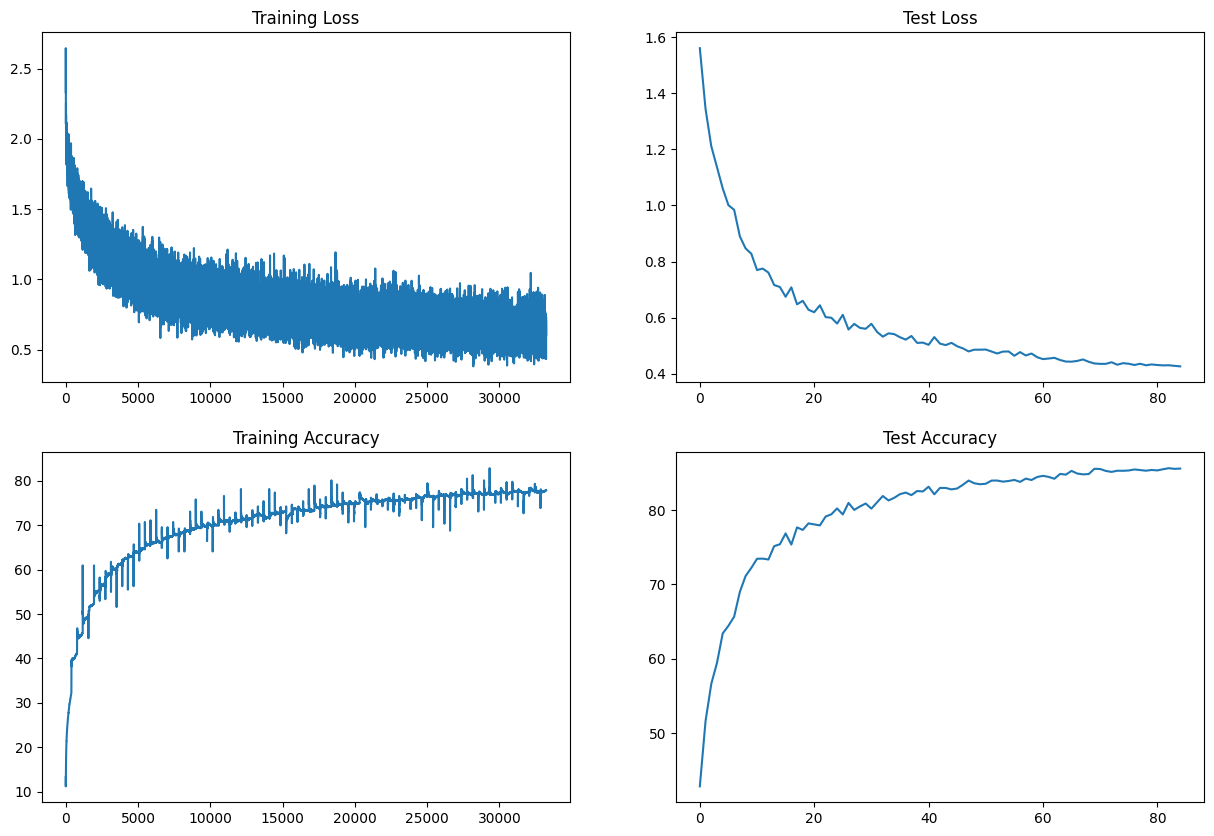

In [10]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")